# Butterworth and Chebyshev filter using Bilinear Transformation method

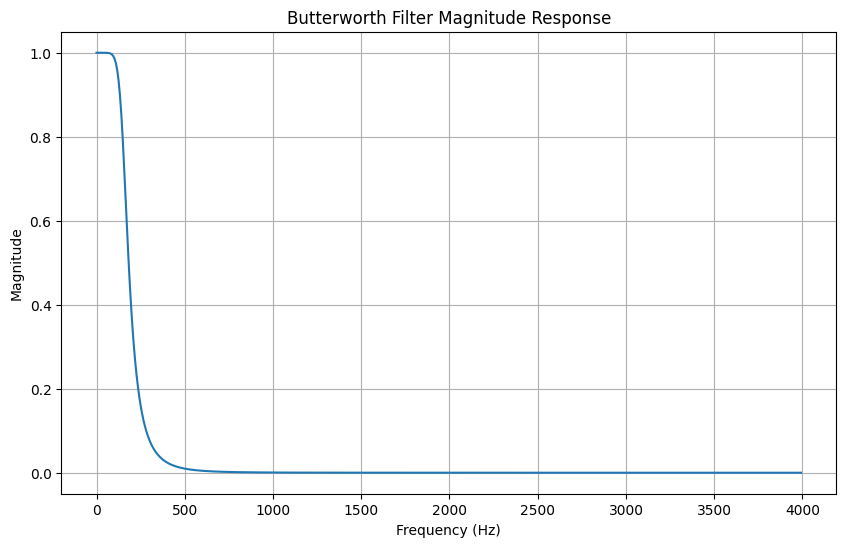

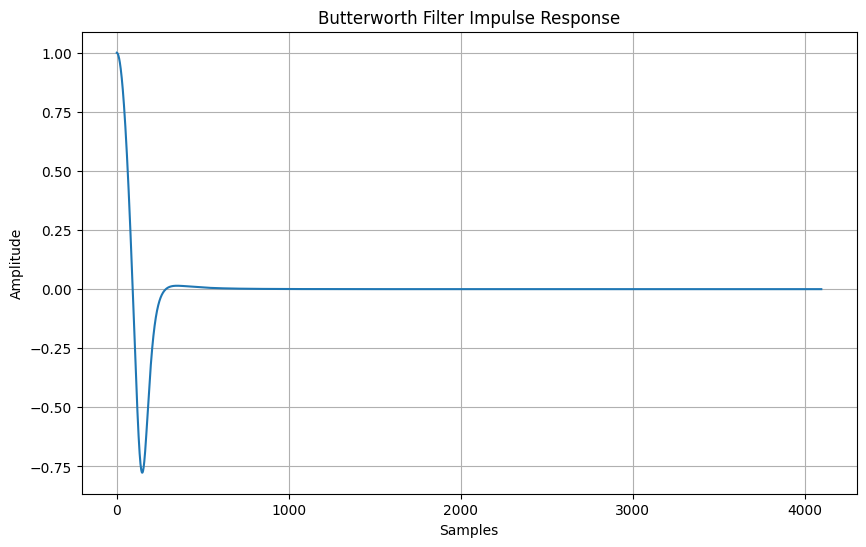

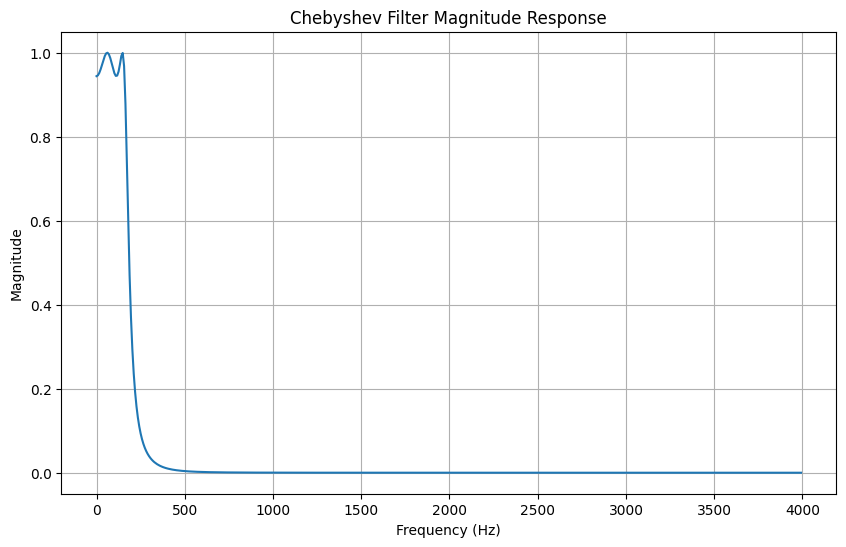

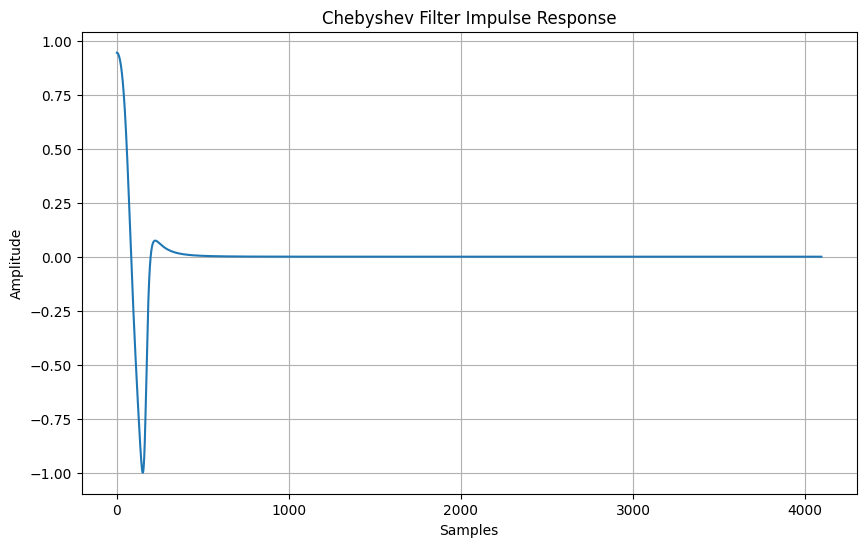

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, bilinear, freqz, cheby1

def design_butterworth_filter(filter_order, cutoff_frequency, sampling_frequency):
    # Design the analog Butterworth filter
    analog_b, analog_a = butter(filter_order, cutoff_frequency, analog=True, btype='low')

    # Perform the bilinear transformation
    digital_b, digital_a = bilinear(analog_b, analog_a, sampling_frequency)

    return digital_b, digital_a

def design_chebyshev_filter(filter_order, cutoff_frequency, sampling_frequency, ripple):
    # Design the analog Chebyshev filter
    analog_b, analog_a = cheby1(filter_order, ripple, cutoff_frequency, analog=True, btype='low')

    # Perform the bilinear transformation
    digital_b, digital_a = bilinear(analog_b, analog_a, sampling_frequency)

    return digital_b, digital_a

def plot_filter_response(digital_b, digital_a, sampling_frequency, filter_name):
    # Compute the frequency response of the filter
    frequency, magnitude_response = freqz(digital_b, digital_a, fs=sampling_frequency)

    # Plot the magnitude response
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, np.abs(magnitude_response))
    plt.title(f'{filter_name} Filter Magnitude Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

    # Compute the impulse response of the filter
    _, impulse_response = freqz(digital_b, digital_a, fs=sampling_frequency, worN=4096)

    # Plot the impulse response
    plt.figure(figsize=(10, 6))
    plt.plot(impulse_response)
    plt.title(f'{filter_name} Filter Impulse Response')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Specify the desired filter specifications
filter_order = 4  # Filter order
cutoff_frequency = 1000  # Cutoff frequency in Hz
sampling_frequency = 8000  # Sampling frequency in Hz
ripple = 0.5  # Ripple factor for Chebyshev filter

# Design the Butterworth filter
digital_b, digital_a = design_butterworth_filter(filter_order, cutoff_frequency, sampling_frequency)

# Plot the Butterworth filter's magnitude response and impulse response
plot_filter_response(digital_b, digital_a, sampling_frequency, 'Butterworth')

# Design the Chebyshev filter
digital_b, digital_a = design_chebyshev_filter(filter_order, cutoff_frequency, sampling_frequency, ripple)

# Plot the Chebyshev filter's magnitude response and impulse response
plot_filter_response(digital_b, digital_a, sampling_frequency, 'Chebyshev')

# Save the filter coefficients (optional)
# filter_path = 'filter_coefficients.txt'
# np.savetxt(filter_path, np.vstack((digital_b, digital_a)), delimiter=',')
# print(f"Filter coefficients saved at: {filter_path}")

# Open Ended Problem

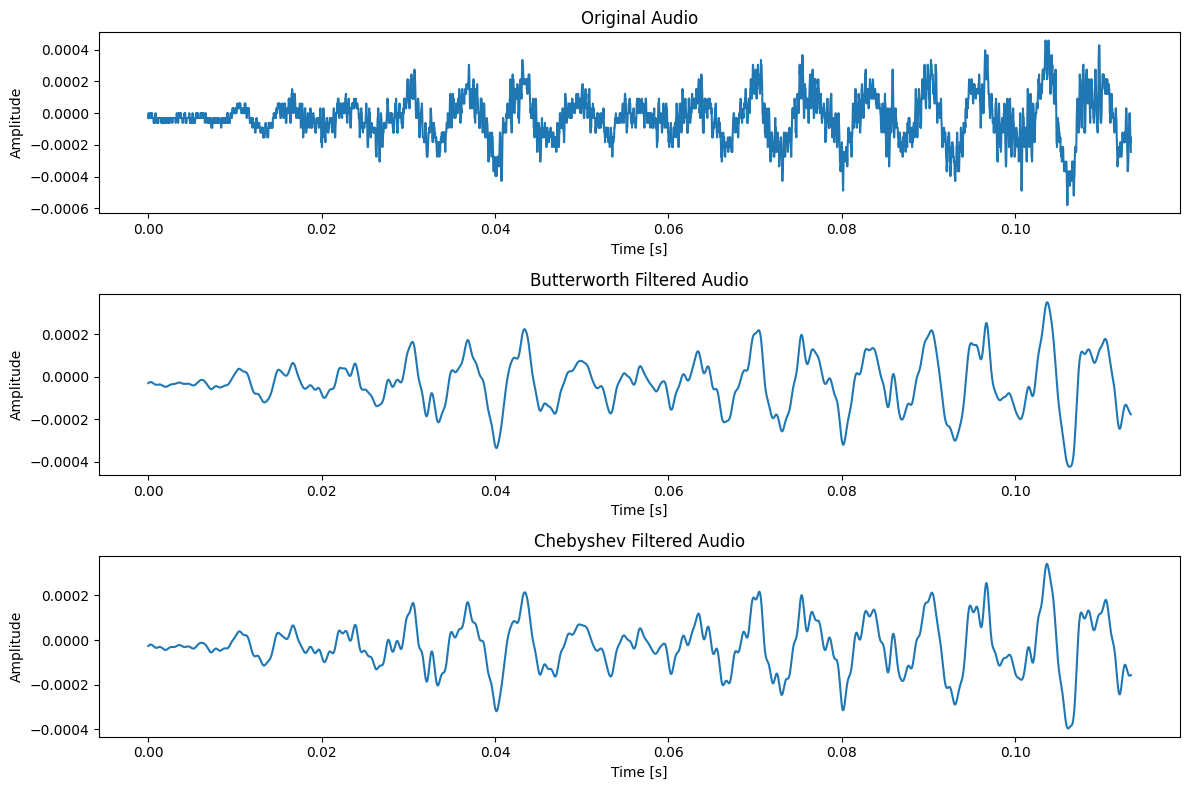

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pydub import AudioSegment
from scipy.signal import butter, cheby1, filtfilt, lfilter

# Function to load MP3 file and convert it into normalized NumPy samples
def load_mp3(path):
    a = AudioSegment.from_file(path)                     
    fs, sw, ch = a.frame_rate, a.sample_width, a.channels 
    samples = np.array(a.get_array_of_samples())         
    # Reshape based on number of channels (mono or stereo)
    samples = samples.reshape((-1, ch)).T if ch > 1 else samples.reshape((1, -1))
    max_int = float(2**(8*sw - 1) - 1)                   
    return samples.astype(np.float32) / max_int, fs, sw, ch  

# Function to save filtered audio back into a file
def save_audio(path, samples_float, fs, sw, ch):
    max_int = int(2**(8*sw - 1) - 1)                     
    # Convert normalized float samples back to integers
    samples_int = np.clip(np.round(
        samples_float * max_int), 
        -max_int, max_int
    ).astype({1:np.int8, 2:np.int16, 4:np.int32}[sw])
    # If stereo, interleave samples; otherwise, flatten for mono
    inter = samples_int.T.flatten() if ch > 1 else samples_int.flatten()
    # Export audio in desired format
    AudioSegment(
        data=inter.tobytes(), 
        sample_width=sw, 
        frame_rate=fs, 
        channels=ch
    ).export(path, format=path.suffix[1:])

# Function to design Butterworth and Chebyshev low-pass filters
def design_filters(order, cutoff_hz, fs, ripple_db=0.5):
    # Create Butterworth low-pass filter
    b_b, a_b = butter(order, cutoff_hz, btype='low', fs=fs)
    # Create Chebyshev Type I low-pass filter
    b_c, a_c = cheby1(order, ripple_db, cutoff_hz, btype='low', fs=fs)
    return (b_b, a_b), (b_c, a_c)

# Function to apply a filter on the audio samples
def apply_filter(b, a, samples, use_filtfilt=True):
    ch, n = samples.shape
    out = np.zeros_like(samples)                          
    padlen = 3 * max(len(a), len(b))                      
    for c in range(ch):                                   
        x = samples[c]
        # Use zero-phase filtering if possible, otherwise use normal filtering
        out[c] = filtfilt(b, a, x) if use_filtfilt and len(x) > padlen else lfilter(b, a, x)
    return out

if __name__ == "__main__":
    # Input audio path
    src = "audio/Exp4/Haan Kar De (PenduJatt.Com.Se).mp3"
    # Output folder for filtered audio files
    out_folder = Path("output_audio/Exp4")

    # Load the audio file
    samples, fs, sw, ch = load_mp3(src)

    # Design two low-pass filters: Butterworth & Chebyshev
    (bb, ab), (bc, ac) = design_filters(4, 1000, fs, ripple_db=0.5)

    # Apply both filters to the samples
    y_butt = apply_filter(bb, ab, samples)
    y_cheb = apply_filter(bc, ac, samples)

    # Prepare output file paths for saving filtered audio
    stem = Path(src).stem
    out_butter = out_folder / f"{stem}_butter.wav"
    out_cheby  = out_folder / f"{stem}_cheby.wav"

    # Save filtered audio files
    save_audio(out_butter, y_butt, fs, sw, ch)
    save_audio(out_cheby, y_cheb, fs, sw, ch)

    # Select one channel (mono or left channel for stereo)
    orig = samples[0]
    butt = y_butt[0]
    cheb = y_cheb[0]

    # Take first 5000 samples for plotting
    N = min(5000, len(orig))
    t = np.arange(N) / fs

    # Plotting original and filtered waveforms
    plt.figure(figsize=(12, 8))

    # Original signal
    plt.subplot(3, 1, 1)
    plt.plot(t, orig[:N])
    plt.title("Original Audio")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    # Butterworth filtered signal
    plt.subplot(3, 1, 2)
    plt.plot(t, butt[:N])
    plt.title("Butterworth Filtered Audio")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    # Chebyshev filtered signal
    plt.subplot(3, 1, 3)
    plt.plot(t, cheb[:N])
    plt.title("Chebyshev Filtered Audio")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Revised Open Ended

Sample rate: 44100, Duration: 245.13 seconds


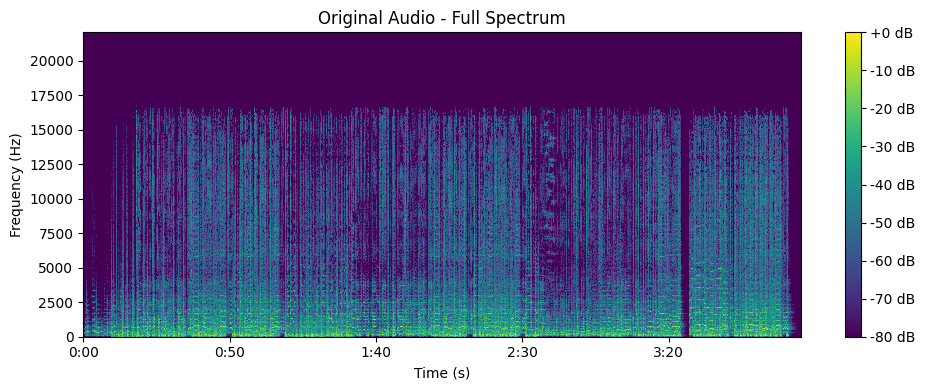

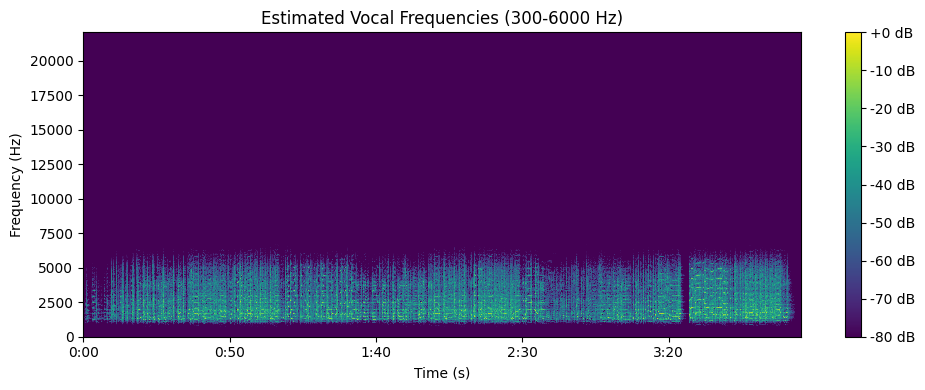

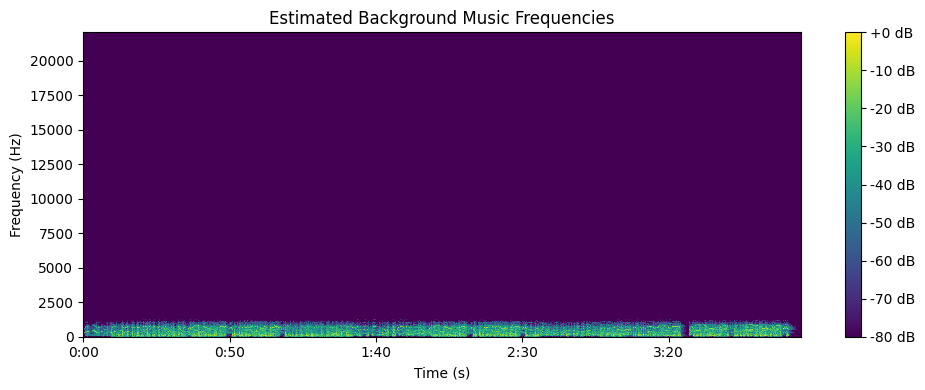

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, sosfiltfilt

# --- 1. Load Audio File ---
filename = 'audio/Exp4/Haan Kar De (PenduJatt.Com.Se).mp3'
y, sr = librosa.load(filename, sr=None)
print(f"Sample rate: {sr}, Duration: {len(y)/sr:.2f} seconds")

# --- 2. Bandpass Filter for Vocals (Speech: 300–3400 Hz) ---
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')  # use SOS
    return sos

def bandpass_filter(data, lowcut, highcut, fs, order=6):
    sos = butter_bandpass(lowcut, highcut, fs, order)
    return sosfiltfilt(sos, data)

vocal_band = bandpass_filter(y, lowcut=1250, highcut=5000, fs=sr)
# estimated_background_band = y - vocal_band Approximation: remaining frequencies as background
estimated_background_band = y - vocal_band
# simple sanitize: replace NaN/Inf with 0
estimated_background_band = np.nan_to_num(estimated_background_band, nan=0.0, posinf=0.0, neginf=0.0)

background_band = bandpass_filter(estimated_background_band, lowcut=20, highcut=800, fs=sr)

# --- 3. Display Spectrograms (STFT) ---
def plot_spectrogram(signal, sr, title):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

plot_spectrogram(y, sr, 'Original Audio - Full Spectrum')
plot_spectrogram(vocal_band, sr, 'Estimated Vocal Frequencies (300-6000 Hz)')
plot_spectrogram(background_band, sr, 'Estimated Background Music Frequencies')

# --- 4. Optional: Save Filtered Audio ---
sf.write('output_audio/Exp4/filtered_vocals.wav', vocal_band, sr)
sf.write('output_audio/Exp4/estimated_background.wav', background_band, sr)